In [1]:
import antropy as ant
import efel
import matplotlib.pyplot as plt
import numpy as np
import sbi
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
import scipy.stats as sps
from scipy.integrate import odeint
import torch

In [2]:
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-notebook')
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.size': 12,
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'grid.linewidth': 0.7,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

In [3]:
def syn_current(t, stim_amp, stim_start, stim_end):
    """Input direct current for a specific moment, `t`.

    Parameters
    ----------
    t : float or numpy.ndarray
        Time as the independent variable [ms]
    stim_amp : float
        Stimulus amplitude [uA/m2]
    stim_start : float
        Time point marking the start of stimulus input [ms]
    stim_end : float
        Time point marking the end of stimulus input [ms]

    Returns
    -------
    float or numpy.ndarray
        Current distribution over time
    """
    return stim_amp * (t > stim_start) - stim_amp * (t > stim_end)


def hodgkin_huxley(y0, t, stim_amp, stim_start, stim_end, g_Na, g_K, g_L,
                   C_m=1, E_Na=50, E_K=-77, E_L=-54.4):
    """Right-hand side of the Hodgkin-Huxley model.

    Parameters
    ----------
    y0 : iterable
        Initial conditions for resting membrane potential and `m`, `h`
        and `n` kinetic variables
    t : numpy.ndarray
        Sequence of time points for which to solve for y
    stim_amp : float
        Stimulus amplitude [uA/m2]
    stim_start : float
        Time point marking the start of stimulus input [ms]
    stim_end : float
        Time point marking the end of stimulus input [ms]
    g_Na : float
        Sodium (Na) maximum conductances [mS/cm^2]
    g_K : float
        Postassium (K) maximum conductances [mS/cm^2]
    g_L : float
        Leak maximum conductances [mS/cm^2]
    C_m : float, optional
        Membrane capacitance [F/cm^2]
    E_Na : float, optional
        Sodium (Na) reversal potentials [mV]
    E_K : float, optional
        Postassium (K) reversal potentials [mV]
    E_L : float, optional
        Leak reversal potentials [mV]

    Returns
    -------
    numpy.ndarray
        State variables dynamics
    """
    V_m, m, h, n = y0
    dV_mdt = ((syn_current(t, stim_amp, stim_start, stim_end)
               - g_Na * m ** 3 * h * (V_m - E_Na)
               - g_K * n ** 4 * (V_m - E_K)
               - g_L * (V_m - E_L)) / C_m)
    dmdt = (0.1 * (V_m + 40) / (1.0 - np.exp(-(V_m + 40) / 10.))
            * (1.0 - m) - 4 * np.exp(-(V_m + 65) / 18.) * m)
    dhdt = (0.07 * np.exp(-(V_m + 65) / 20) * (1 - h)
            - 1 / (1.0 + np.exp(-(V_m + 35) / 10.)) * h)
    dndt = (0.01 * (V_m + 55) / (1.0 - np.exp(-(V_m + 55) / 10))
            * (1 - n) - 0.125 * np.exp(-(V_m + 65) / 80) * n)
    return np.hstack([dV_mdt, dmdt, dhdt, dndt])


def solve_hodgkin_huxley(params, y0, t, stim_amp, stim_start, stim_end, C_m=1,
                         E_Na=50, E_K=-77, E_L=-54.4, add_noise=True,
                         return_full=False):
    """Wrapper for the `odeint` ODE solver.

    Parameters
    ----------
    params : iterable
        Ion channel conductances treated as free parameters to be
        determined
    y0 : iterable
        Initial conditions for resting membrane potential and `m`, `h`
        and `n` kinetic variables
    t : numpy.ndarray
        Sequence of time points for which to solve for y
    stim_amp : float
        Stimulus amplitude [uA/m2]
    stim_start : float
        Time point marking the start of stimulus input [ms]
    stim_end : float
        Time point marking the end of stimulus input [ms]
    C_m : float, optional
        Membrane capacitance [uF/cm^2]
    E_Na : float, optional
        Sodium (Na) reversal potentials [mV]
    E_K : float, optional
        Postassium (K) reversal potentials [mV]
    E_L : float, optional
        Leak reversal potentials [mV]
    add_noise : bool, optional
        If set to True, white noise will be added to the voltage trace
        after simulation, otherwise the voltage trace will be noiseless
    return_full : bool, optional
        If set to True, the raw output from `scipy.integrate.odeint` is
        going to be returned

    Returns
    -------
    numpy.ndarray
        Membrane potential [mV] time series
    """
    args = (stim_amp, stim_start, stim_end, *params, C_m, E_Na, E_K, E_L)
    sol = odeint(hodgkin_huxley, y0, t, args=args)
    voltage = sol[:, 0]
    if add_noise:
        neural_noise = (0.05 * voltage * np.random.randn(*voltage.shape))
        voltage += neural_noise
    if return_full:
        return sol
    return voltage


def simulator(params):
    """Return relevant electrophysiological features for likelihood
    free inference.

    Parameters
    ----------
    params : iterable
        Parameters to learn

    Returns
    -------
    numpy.ndarray
        Signal features
    """
    V_m = solve_hodgkin_huxley(params, y0, t, stim_amp, stim_start, stim_end)
    trace = {}
    trace['T'] = t
    trace['V'] = V_m
    trace['stim_start'] = [stim_start]
    trace['stim_end'] = [stim_end]

    feature_names = [
        'AP_amplitude',
        'steady_state_voltage',
        'voltage_base',
        'Spikecount',
        'mean_frequency',
        'time_to_first_spike'
    ]

    feature_values = efel.getFeatureValues([trace], feature_names)[0]
    mean_active_potential = np.asarray(
        np.mean(V_m[(t > stim_start) & (t < stim_end)])
    )
    std_active_potential = np.asarray(
        np.std(V_m[(t > stim_start) & (t < stim_end)])
    )
    skew_active_potential = np.asarray(
        sps.skew(V_m[(t > stim_start) & (t < stim_end)], bias=False)
    )
    kurt_active_potential = np.asarray(
        sps.kurtosis(V_m[(t > stim_start) & (t < stim_end)], bias=False)
    )
    voltage_base = feature_values['voltage_base']
    steady_state_voltage = feature_values['steady_state_voltage']
    mean_ap_amplitude = np.asarray(
        np.mean(feature_values['AP_amplitude'])
    )
    spike_count = feature_values['Spikecount']
    time_to_first_spike = feature_values['time_to_first_spike']
    perm_entropy = np.asarray(ant.perm_entropy(Vm))
    svd_entropy = np.asarray(ant.svd_entropy(Vm))
    sum_stats_vec = np.hstack((
        mean_active_potential,
        #std_active_potential,
        #skew_active_potential,
        #kurt_active_potential,
        #voltage_base,
        steady_state_voltage,
        mean_ap_amplitude,
        spike_count,
        time_to_first_spike,
        perm_entropy,
        svd_entropy,
    ))
    return sum_stats_vec

In [4]:
# Hodgkin-Huxley model parameters
stim_amp = 10
stim_start = 100
stim_end = 400

# ion channel conductances are considered unknown
g_Na = 120
g_K = 36
g_L = 0.3
true_params = np.array([g_Na, g_K, g_L])

# initial conditions
y0 = [-65., 0.0529, 0.5916, 0.3177]

# simulation times in milliseconds
t = np.arange(0., 500., 0.1)

# measured membrane voltage trace
I = syn_current(t, stim_amp, stim_start, stim_end)
Vm = solve_hodgkin_huxley(true_params, y0, t, stim_amp, stim_start, stim_end)

In [5]:
# prior over the unknowns
prior_min = [90, 20, 0.01]
prior_max = [150, 50, 1.0]
prior = sbi.utils.torchutils.BoxUniform(low=torch.tensor(prior_min),
                                        high=torch.tensor(prior_max))

In [6]:
# prepare simulator, prior and for usage in sbi and create the dataset
_simulator, _prior = prepare_for_sbi(simulator, prior)
theta, x = simulate_for_sbi(simulator=_simulator,
                            proposal=_prior,
                            num_simulations=1000,
                            num_workers=4)

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
# creating a density estimator
inference = SNPE(_prior)
inference = inference.append_simulations(theta, x)
density_estimator = inference.train()

Neural network successfully converged after 167 epochs.


In [8]:
# build posterior from the neural density estimator
posterior = inference.build_posterior(density_estimator)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

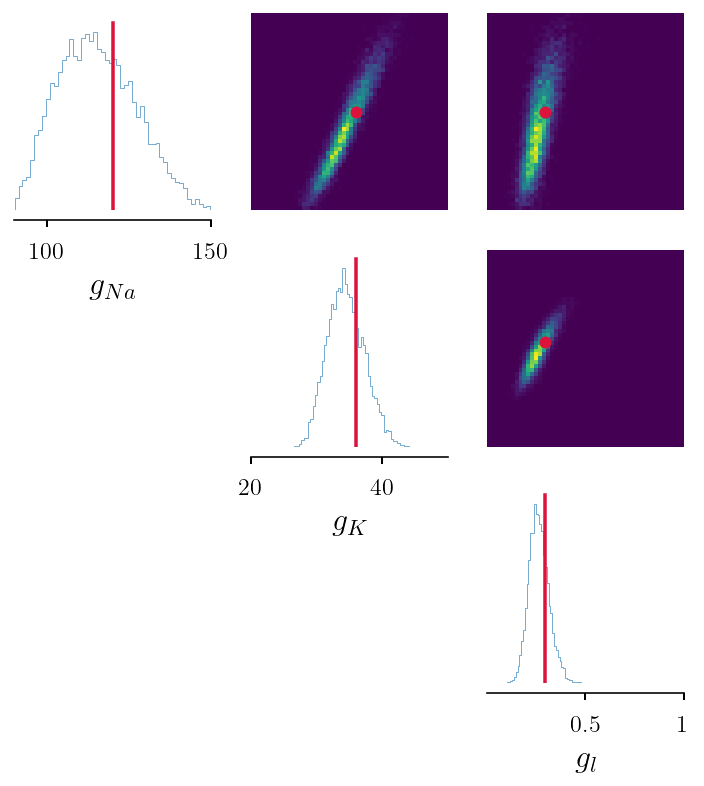

In [9]:
# analysis of the posterior given "observed" data
posterior_samples = posterior.sample((10000, ), x=simulator(true_params))
_ = analysis.pairplot(posterior_samples,
                      points=true_params,
                      points_offdiag={'markersize': 12},
                      points_colors=['crimson'],
                      labels=['$g_{Na}$', '$g_{K}$', '$g_{l}$'],
                      limits=[[m, n] for m, n in zip(prior_min, prior_max)],
                      figsize=(6, 6))
plt.show()

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

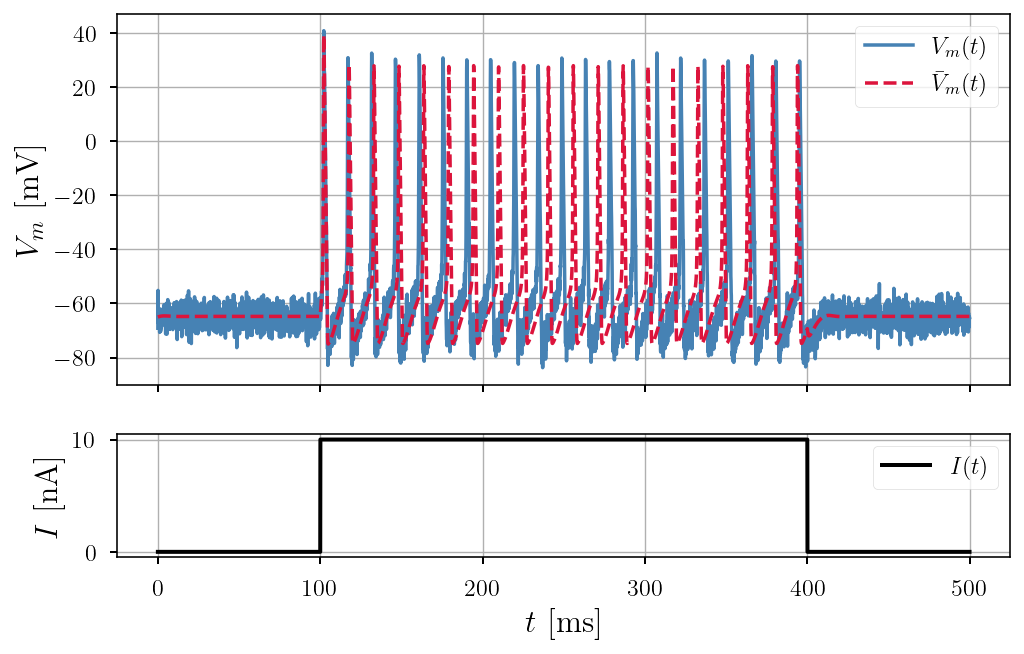

In [10]:
# simulation using fitted conductance parameters
posterior_sample = posterior.sample((1, ), x=simulator(true_params)).numpy().ravel()
Vm_fit = solve_hodgkin_huxley(posterior_sample, y0, t, stim_amp, stim_start,
                              stim_end, add_noise=False)
fig, ax = plt.subplots(2, 1, sharex=True,
                       gridspec_kw={'height_ratios': [3, 1]}, figsize=(8, 5))
ax[0].plot(t, Vm, 'steelblue', label='$V_m(t)$')
ax[0].plot(t, Vm_fit, '--', c='crimson', label=r'$\bar V_m(t)$')
ax[0].set_ylabel('$V_m$ [mV]')
ax[0].grid()
ax[0].legend()
ax[1].plot(t, I, 'k-', linewidth=2, label='$I(t)$')
ax[1].set_xlabel('$t$ [ms]')
ax[1].set_ylabel('$I$ [nA]')
ax[1].grid()
ax[1].legend()
plt.show()